# Navigation

---

For this project, you will train an agent to navigate (and collect bananas!) in a large, square world.

If running on the Udacity Workspace, the environment is already saved in the Workspace and can be accessed at the file path provided below. When running locally change the os variable (MACOS, LINUX, WINDOWS_32, WINDOWS_64) to match your OS

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import timeit

os = 'MACOS'
os_env = {
    'LINUX_X86': "./envs/⁨VisualBanana_Linux⁩/Banana.x86",
    'LINUX_X86_64': "./envs/⁨VisualBanana_Linux⁩/Banana.x86_64",
    'MACOS': "./envs/Banana.app",
    'WINDOWS_X86_32': "./envs/VisualBanana_Windows_x86/Banana.exe",
    'WINDOWS_X86_64': "./envs/VisualBanana_Windows_x86_64/Banana.exe",
}


print('Running on self built enviroment')
env = UnityEnvironment(file_name=os_env[os])

Running on self built enviroment


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Environment and Brains
Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Architecture

#### Agent

The Agent uses 2 FeedForward Networks and a ReplyBuffer to interact with the environment to accomplish the episodic tasks. It uses the Eplison Greedy method to select the action with a starting epsilon of 1.0. The epsilon is decayed over the episodes using a decay rate of 0.995 with an ending epsilon of 0.01.
   - Replay Buffer: It stores the experience that the agent observes, allowing us to reuse this data later. This allows the agent to sample the transistions randomly reducing the correlation in a batch. This has been shown to stablize and improve the DQN training. The buffer is a a cyclic buffer of bounded size that holds the experiences observed recently. It also implements a .sample() method for selecting a random batch of experiences for training. Each experience stored is actually a NamedTuple containing a single a named tuple representing a single interaction with the environment. It essentially maps (state, action) pairs to their (next_state, reward, done) result.
   - Target network: This network is compared to the local network minimize the error better the 2 to maximize the reward to solve the task. The agent randomly initialized it at a start and it is updated everytime the buffer hits the batch size. The update is performed by picking random samples from the Replay Buffer to get the bast action for a given state.
   - Local network: This network takes a state as input and outputs an action, it uses the epsilon, to perform epsilon-greedy action selection

It takes in the following parameters during contruction:
1. device - Allows the training to switch between running on the CPU or GPU
2. memory - ReplayBuffer instance use for experience replay. This allows the ReplayBuffer class to be abstracted from the network and agent implementation.
3. action_size - Possible actions for action
4. state_size - Number of states in the environment
5. batch_size - Variable used to control the number of random samples to select for training
6. gamma - Discount factor used to calculate the targetted rewards
7. lr - Learning rate used by the optimizer for training
8. update_every - Indicates the number of time steps to occur before the agent attempts to learn
9. tau - weighting factor used to update the target network
10. hidden_layer_lengths - Allows the customization of the size in the full connected layers

#### Contructor

The constructor of the agent takes care of creating the local network, target network and an Adam optimizer.

#### Methods
1. act
This method is called with the current state which the agent uses with the epsilon-greedy action selector to get the next action to perform.
2. step
This method takes in the `state, action, reward, next_state, done` values that were obtained from performing the action obtained from the act method previously. Internally it stores the inputs into the ReplayBuffer. And during every `update_every` step it will trigger the learn method on a random sample of responses if the memory capacity is greater than the `batch_size` 
3. learn
This method will calculate the target rewards and calculate the loss against the Q values in the local network using the `MSELoss` function. It will then perform any required optimization using the optimizer. And it will trigger the `soft_update` method
4. soft_update
This method will perform an update on the parameters in the target network.

#### Network

The network has 3 feed forward layers:
1. fc1 - in:state_size, out:hidden_layer_lengths
2. relu: activation for adding nonlinearity
3. fc2 - in:hidden_layer_lengths, out:hidden_layer_lengths
4. relu: activation for adding nonlinearity
5. fc3: in:hidden_layer_lengths, out:action_size

In [4]:
class ReplayBuffer:
    '''Fixed-size buffer to store experience tuples.'''
    
    def __init__(self, device, action_size, buffer_size, batch_size):
        '''Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        '''
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.device = device
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        
    def add(self, state, action, reward, next_state, done):
        '''Add a new experience to memory.'''
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        '''Randomly sample a batch of experiences from memory.'''
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        '''Return the current size of internal memory.'''
        return len(self.memory)

### Training

The training method has been abstracted and it takes the following arguments:
- checkpoint_filename (string): name to store the saved state of successful agent action
- agent: agent that implements the methods act and step with a qnetwork_local propery
- n_episodes (int): maximum number of training episodes
- max_t (int): maximum number of timesteps per episode
- eps_start (float): starting value of epsilon, for epsilon-greedy action selection
- eps_end (float): minimum value of epsilon
- eps_decay (float): multiplicative factor (per episode) for decreasing epsilon

This follows different types of agents to use the same training method as follows:
1. Obtain the next action to perform against the environment from the agent
2. Perform the action against the environment and obtained the new `reward, next_state, done` values
3. Call step on the agent with `state, action, reward, next_state, done` to perform the learn operation from the new parameters obtained from the environment
4. Calculate the rewards accumulated and persist the state of the model if the target accumulated reward is obtained

In [5]:
import numpy as np
from collections import namedtuple, deque

import random
import torch
from qnetwork.agent import Agent as QNetwork_Agent

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

def train(checkpoint_filename, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Params
    ======
        checkpoint_filename (string): name to store the saved state of successful agent action
        agent: agent that implements the methods act and step with a qnetwork_local propery
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = [] # list to store scores from each episode
    scores_window = deque(maxlen=100) # last 100 scores
    eps = eps_start # initialize epsilon
    
    average_score = 0.0
    best_average_score = 0.0
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]         # send the action to the environment
            next_state = env_info.vector_observations[0]    # get the next state
            reward = env_info.rewards[0]                    # get the reward
            done = env_info.local_done[0]                   # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state                              # update the score
            score += reward
            if done:
                break
        
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        eps = max(eps_end, eps_decay * eps) # decrease epsilon
        
        average_score = np.mean(scores_window)
        print(f'\rEpisode {i_episode}\tAverage Score: {average_score:.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {average_score:.2f}')
            
        if average_score >= 13.0 and average_score > best_average_score:
            best_average_score = average_score
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))
            torch.save(agent.qnetwork_local.state_dict(), checkpoint_filename)

    return scores

Setup variables and utility functions for using Q Network. `testWrapper` is a utility method for timing the training process.

In [6]:
def runQNetworkTest(checkpoint_filename, buffer_size, batch_size, gamma, lr, update_every, tau, hidden_layer_lengths):
    memory = ReplayBuffer(device, action_size, buffer_size, batch_size)
    agent = QNetwork_Agent(
        device, memory, action_size, state_size,
        batch_size, gamma, lr, update_every, tau, hidden_layer_lengths
    )

    scores = train(checkpoint_filename, agent)

    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

def testWrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

##### Test Case

BUFFER_SIZE = 100,000
BATCH_SIZE = 64         
GAMMA = 0.99            
TAU = 1e-3              
LR = 5e-4               
UPDATE_EVERY = 4        

Run using Buffer Size of 100,000

Episode 100	Average Score: 0.85
Episode 200	Average Score: 4.52
Episode 300	Average Score: 8.10
Episode 400	Average Score: 10.11
Episode 500	Average Score: 12.92
Episode 525	Average Score: 13.02
Environment solved in 525 episodes!	Average Score: 13.02
Episode 526	Average Score: 13.03
Environment solved in 526 episodes!	Average Score: 13.03
Episode 527	Average Score: 13.16
Environment solved in 527 episodes!	Average Score: 13.16
Episode 528	Average Score: 13.22
Environment solved in 528 episodes!	Average Score: 13.22
Episode 529	Average Score: 13.23
Environment solved in 529 episodes!	Average Score: 13.23
Episode 530	Average Score: 13.35
Environment solved in 530 episodes!	Average Score: 13.35
Episode 531	Average Score: 13.45
Environment solved in 531 episodes!	Average Score: 13.45
Episode 532	Average Score: 13.49
Environment solved in 532 episodes!	Average Score: 13.49
Episode 533	Average Score: 13.51
Environment solved in 533 episodes!	Average Score: 13.51
Episode 534	Average Score: 1

Episode 1933	Average Score: 16.45
Environment solved in 1933 episodes!	Average Score: 16.45
Episode 1935	Average Score: 16.48
Environment solved in 1935 episodes!	Average Score: 16.48
Episode 1938	Average Score: 16.51
Environment solved in 1938 episodes!	Average Score: 16.51
Episode 2000	Average Score: 15.84


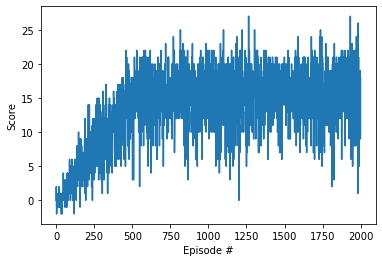

Time Taken: 1651.8256685069937


In [7]:
# 64 Hidden Layers
wrapped = testWrapper(runQNetworkTest, 'checkpoint-100000.pth', BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')

#### 5.b Run using Buffer Size of 200,000

Episode 100	Average Score: 0.69
Episode 200	Average Score: 3.45
Episode 300	Average Score: 6.95
Episode 400	Average Score: 10.54
Episode 500	Average Score: 12.34
Episode 538	Average Score: 13.01
Environment solved in 538 episodes!	Average Score: 13.01
Episode 539	Average Score: 13.02
Environment solved in 539 episodes!	Average Score: 13.02
Episode 540	Average Score: 13.16
Environment solved in 540 episodes!	Average Score: 13.16
Episode 542	Average Score: 13.17
Environment solved in 542 episodes!	Average Score: 13.17
Episode 546	Average Score: 13.24
Environment solved in 546 episodes!	Average Score: 13.24
Episode 547	Average Score: 13.30
Environment solved in 547 episodes!	Average Score: 13.30
Episode 548	Average Score: 13.40
Environment solved in 548 episodes!	Average Score: 13.40
Episode 549	Average Score: 13.44
Environment solved in 549 episodes!	Average Score: 13.44
Episode 550	Average Score: 13.50
Environment solved in 550 episodes!	Average Score: 13.50
Episode 559	Average Score: 1

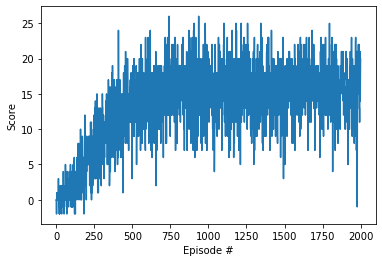

Time Taken: 1728.554216582008


In [8]:
wrapped = testWrapper(runQNetworkTest, 'checkpoint-200000.pth', int(2e5), BATCH_SIZE, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')

#### 5.c Run using Buffer Size of 250,000

Episode 100	Average Score: 0.97
Episode 200	Average Score: 4.04
Episode 300	Average Score: 7.39
Episode 400	Average Score: 10.55
Episode 500	Average Score: 10.72
Episode 600	Average Score: 11.75
Episode 700	Average Score: 12.65
Episode 780	Average Score: 13.01
Environment solved in 780 episodes!	Average Score: 13.01
Episode 781	Average Score: 13.09
Environment solved in 781 episodes!	Average Score: 13.09
Episode 782	Average Score: 13.19
Environment solved in 782 episodes!	Average Score: 13.19
Episode 783	Average Score: 13.20
Environment solved in 783 episodes!	Average Score: 13.20
Episode 784	Average Score: 13.26
Environment solved in 784 episodes!	Average Score: 13.26
Episode 786	Average Score: 13.43
Environment solved in 786 episodes!	Average Score: 13.43
Episode 790	Average Score: 13.55
Environment solved in 790 episodes!	Average Score: 13.55
Episode 800	Average Score: 13.40
Episode 830	Average Score: 13.59
Environment solved in 830 episodes!	Average Score: 13.59
Episode 831	Average

Episode 1539	Average Score: 16.43
Environment solved in 1539 episodes!	Average Score: 16.43
Episode 1543	Average Score: 16.49
Environment solved in 1543 episodes!	Average Score: 16.49
Episode 1544	Average Score: 16.51
Environment solved in 1544 episodes!	Average Score: 16.51
Episode 1546	Average Score: 16.67
Environment solved in 1546 episodes!	Average Score: 16.67
Episode 1547	Average Score: 16.77
Environment solved in 1547 episodes!	Average Score: 16.77
Episode 1561	Average Score: 16.82
Environment solved in 1561 episodes!	Average Score: 16.82
Episode 1562	Average Score: 16.88
Environment solved in 1562 episodes!	Average Score: 16.88
Episode 1563	Average Score: 16.91
Environment solved in 1563 episodes!	Average Score: 16.91
Episode 1565	Average Score: 16.92
Environment solved in 1565 episodes!	Average Score: 16.92
Episode 1566	Average Score: 16.96
Environment solved in 1566 episodes!	Average Score: 16.96
Episode 1600	Average Score: 16.53
Episode 1700	Average Score: 15.24
Episode 1800

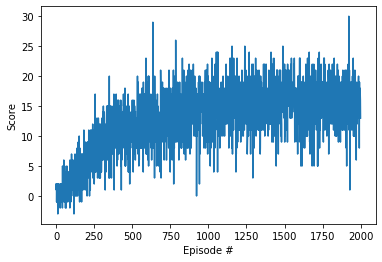

Time Taken: 1790.1120206429914


In [9]:
wrapped = testWrapper(runQNetworkTest, 'checkpoint-250000.pth', int(2.5e5), BATCH_SIZE, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')

#### 5.d Run using Buffer Size of 100,000 and Batch Size 32

Episode 100	Average Score: 0.61
Episode 200	Average Score: 3.78
Episode 300	Average Score: 8.00
Episode 400	Average Score: 10.56
Episode 500	Average Score: 12.57
Episode 520	Average Score: 13.02
Environment solved in 520 episodes!	Average Score: 13.02
Episode 521	Average Score: 13.06
Environment solved in 521 episodes!	Average Score: 13.06
Episode 522	Average Score: 13.08
Environment solved in 522 episodes!	Average Score: 13.08
Episode 523	Average Score: 13.14
Environment solved in 523 episodes!	Average Score: 13.14
Episode 524	Average Score: 13.17
Environment solved in 524 episodes!	Average Score: 13.17
Episode 525	Average Score: 13.19
Environment solved in 525 episodes!	Average Score: 13.19
Episode 536	Average Score: 13.29
Environment solved in 536 episodes!	Average Score: 13.29
Episode 537	Average Score: 13.40
Environment solved in 537 episodes!	Average Score: 13.40
Episode 538	Average Score: 13.43
Environment solved in 538 episodes!	Average Score: 13.43
Episode 547	Average Score: 1

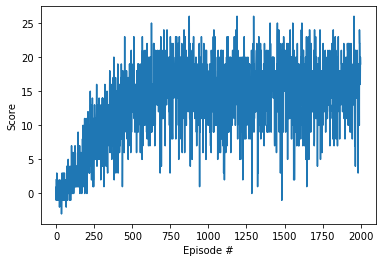

Time Taken: 1593.5201363289962


In [10]:
wrapped = testWrapper(runQNetworkTest, 'checkpoint-100000x32.pth', int(1e5), 32, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')

#### 5.e Run using Buffer Size of 200,000 and Batch Size 32

Episode 100	Average Score: 1.02
Episode 200	Average Score: 4.39
Episode 300	Average Score: 7.98
Episode 400	Average Score: 9.943
Episode 500	Average Score: 11.08
Episode 600	Average Score: 12.77
Episode 664	Average Score: 13.05
Environment solved in 664 episodes!	Average Score: 13.05
Episode 670	Average Score: 13.06
Environment solved in 670 episodes!	Average Score: 13.06
Episode 671	Average Score: 13.10
Environment solved in 671 episodes!	Average Score: 13.10
Episode 672	Average Score: 13.12
Environment solved in 672 episodes!	Average Score: 13.12
Episode 673	Average Score: 13.17
Environment solved in 673 episodes!	Average Score: 13.17
Episode 675	Average Score: 13.24
Environment solved in 675 episodes!	Average Score: 13.24
Episode 677	Average Score: 13.28
Environment solved in 677 episodes!	Average Score: 13.28
Episode 678	Average Score: 13.42
Environment solved in 678 episodes!	Average Score: 13.42
Episode 693	Average Score: 13.48
Environment solved in 693 episodes!	Average Score: 1

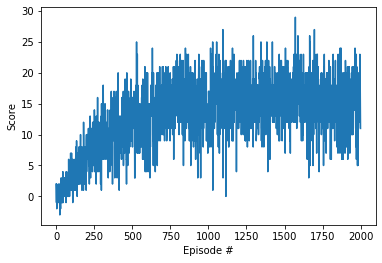

Time Taken: 1621.5029886100092


In [11]:
wrapped = testWrapper(runQNetworkTest, 'checkpoint-200000x32.pth', int(2e5), 32, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')

#### 5.f Run using Buffer Size of 250,000 and Batch Size 32

Episode 100	Average Score: 1.08
Episode 200	Average Score: 5.17
Episode 300	Average Score: 8.73
Episode 400	Average Score: 11.28
Episode 500	Average Score: 11.93
Episode 600	Average Score: 12.74
Episode 613	Average Score: 13.02
Environment solved in 613 episodes!	Average Score: 13.02
Episode 654	Average Score: 13.08
Environment solved in 654 episodes!	Average Score: 13.08
Episode 656	Average Score: 13.12
Environment solved in 656 episodes!	Average Score: 13.12
Episode 663	Average Score: 13.16
Environment solved in 663 episodes!	Average Score: 13.16
Episode 664	Average Score: 13.28
Environment solved in 664 episodes!	Average Score: 13.28
Episode 665	Average Score: 13.38
Environment solved in 665 episodes!	Average Score: 13.38
Episode 666	Average Score: 13.47
Environment solved in 666 episodes!	Average Score: 13.47
Episode 667	Average Score: 13.53
Environment solved in 667 episodes!	Average Score: 13.53
Episode 670	Average Score: 13.63
Environment solved in 670 episodes!	Average Score: 1

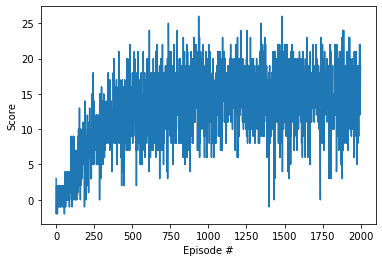

Time Taken: 1667.0391814080067


In [12]:
wrapped = testWrapper(runQNetworkTest, 'checkpoint-250000x32.pth', int(2.5e5), 32, GAMMA, LR, UPDATE_EVERY, TAU, { 'fc1': 64, 'fc2': 64 })
print(f'Time Taken: {timeit.timeit(wrapped, number=1)}')